## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [3]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [4]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [5]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.
env = TicTacToe()
def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [6]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [7]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()
    if z > epsilon:
        #Q value fetch max value
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get) #Exploitation: gets the action corresponding to max q-value of current state
    else:
        #random action generation
        agent_actions = [i for i in env.action_space(state)[0]]
       
        action = agent_actions[np.random.choice(range(len(agent_actions)))] #Exploration: randomly choosing and action
        
    return action




#### Tracking the state-action pairs for checking convergence - write your code here

In [8]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
print(len(Q_dict))
print(len(States_track))

0
0


In [9]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-x-x-4-x-3-x-x-x',(0, 1)),('3-x-6-x-4-x-x-x-7',(6, 5)),#taking 4 sample state-actions 
                       ('x-x-5-x-8-9-x-x-4',(0, 3)),('x-1-x-3-x-2-x-x-4',(2, 7))]
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        #state1 = Q_state(state)
        States_track[state][action] = []  
  

In [10]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [12]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [13]:
EPISODES = 5000000 #given 5M
LR = 0.01                   #learning rate
GAMMA = 0.91

max_epsilon = 1.0
min_epsilon = 0.001

threshold = 4000      
policy_threshold = 40000

### Q-update loop ---write your code here

In [36]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe()
    curr_state = env.state
    Terminal = False
    add_to_dict(curr_state)
    total_reward = 0
    reward = None
    while not Terminal:
        current_state_str = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, Terminal = env.step(curr_state, curr_action)
        
        next_state_str = Q_state(next_state)
        add_to_dict(next_state)
        
        if not Terminal:
            max_next = max(Q_dict[next_state_str],key=Q_dict[next_state_str].get)#this gives the action corresponding to max q-value of next state
            Q_dict[current_state_str][curr_action] += LR * ((reward + (GAMMA * (Q_dict[next_state_str][max_next]))) -
                Q_dict[current_state_str][curr_action])
        else:
            Q_dict[current_state_str][curr_action] += LR * ((reward - Q_dict[current_state_str][curr_action]))
        
        curr_state = next_state
        total_reward += reward
        
     #TRACKING Q-VALUES
    if (episode == threshold-1):        #at 3999 episodes
        initialise_tracking_states()

    if ((episode + 1) % threshold) == 0:   #4000 episodes
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    #SAVING POLICY
    if ((episode + 1)% policy_threshold ) == 0:  #40000 episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')
        
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

In [37]:
print(elapsed_time)

4745.530019044876


#### Check the Q-dictionary

In [38]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.3080652792296805,
              (0, 3): -1.3411441157988946,
              (0, 5): -1.3409966901666552,
              (0, 7): -1.3283468105823846,
              (0, 9): -1.346268663478929,
              (1, 1): -1.3410618350577364,
              (1, 3): -1.3355423613523965,
              (1, 5): -1.240972950772226,
              (1, 7): -1.3403425892372354,
              (1, 9): -1.3224882854945472,
              (2, 1): -1.2420552356653602,
              (2, 3): -1.3332679706076096,
              (2, 5): -1.2983464140825958,
              (2, 7): -1.3375339228445156,
              (2, 9): -1.1931577243711429,
              (3, 1): -1.3270342473973207,
              (3, 3): -1.305988485147992,
              (3, 5): -1.1789620936451706,
              (3, 7): -1.3286487593209046,
              (3, 9): -1.30410852660998,
              (4, 1): -1.2891537815456107,
              (4, 3): -1.3322608279468897,
              (4, 5)

In [39]:
len(Q_dict)

2395302

In [40]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

In [41]:
States_track['x-x-x-4-x-3-x-x-x'][(0, 1)]

[0,
 -0.01,
 -0.0199,
 -0.0199,
 -0.0199,
 -0.0199,
 -0.0199,
 -0.0199,
 -0.0199,
 -0.0199,
 -0.029701,
 -0.03940399,
 -0.03940399,
 -0.03940399,
 -0.03940399,
 -0.03940399,
 -0.03940399,
 -0.03940399,
 -0.03940399,
 -0.03940399,
 -0.0490099501,
 -0.0490099501,
 -0.0490099501,
 -0.0490099501,
 -0.0490099501,
 -0.0490099501,
 -0.0490099501,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519850599,
 -0.058519

In [42]:
States_track['3-x-6-x-4-x-x-x-7'][(6, 5)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [43]:
States_track['x-x-5-x-8-9-x-x-4'][(0, 3)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0

In [45]:
States_track['x-1-x-3-x-2-x-x-4'][(2, 7)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


#### Check the states tracked for Q-values convergence
(non-evaluative)

In [46]:
# Write the code for plotting the graphs for state-action pairs tracked

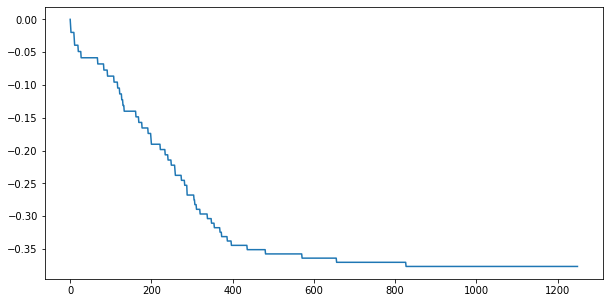

In [47]:
S1 = np.arange(len(States_track['x-x-x-4-x-3-x-x-x'][(0, 1)]))
plt.figure(0, figsize=(10,5))

plt.plot(S1,np.array(States_track['x-x-x-4-x-3-x-x-x'][(0, 1)]))
plt.show()

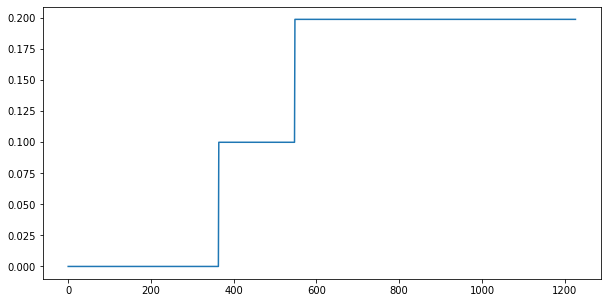

In [48]:
S2 = np.arange(len(States_track['3-x-6-x-4-x-x-x-7'][(6, 5)]))
plt.figure(0, figsize=(10,5))

plt.plot(S2,np.array(States_track['3-x-6-x-4-x-x-x-7'][(6, 5)]))
plt.show()

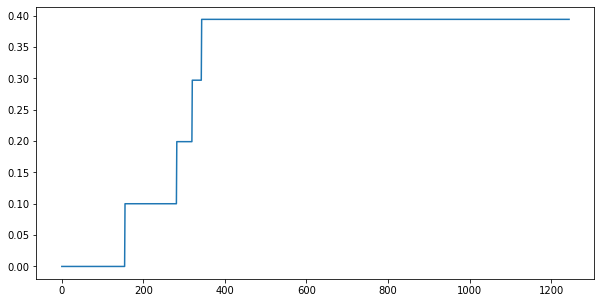

In [49]:
S3 = np.arange(len(States_track['x-x-5-x-8-9-x-x-4'][(0, 3)]))
plt.figure(0, figsize=(10,5))

plt.plot(S3,np.array(States_track['x-x-5-x-8-9-x-x-4'][(0, 3)]))
plt.show()

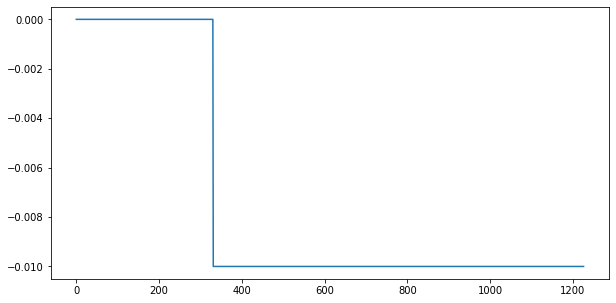

In [50]:
S4 = np.arange(len(States_track['x-1-x-3-x-2-x-x-4'][(2, 7)]))
plt.figure(0, figsize=(10,5))

plt.plot(S4,np.array(States_track['x-1-x-3-x-2-x-x-4'][(2, 7)]))
plt.show()

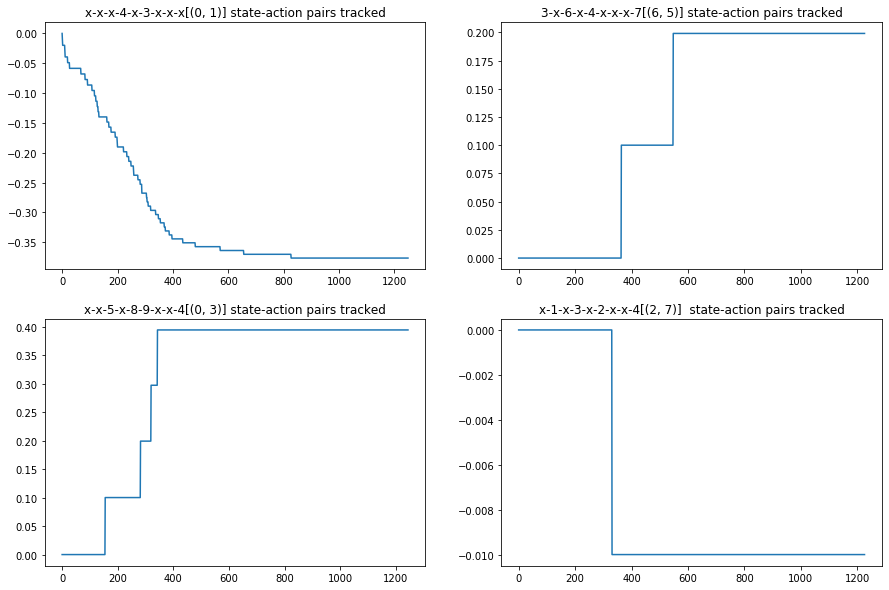

In [53]:
plt.figure(0, figsize=(15,10))

S1 = np.asarray(range(0, len(States_track['x-x-x-4-x-3-x-x-x'][(0, 1)])))
plt.subplot(221)
plt.title('x-x-x-4-x-3-x-x-x[(0, 1)] state-action pairs tracked')
plt.plot(S1,np.asarray(States_track['x-x-x-4-x-3-x-x-x'][(0, 1)]))

S2 = np.asarray(range(0, len(States_track['3-x-6-x-4-x-x-x-7'][(6, 5)])))
plt.subplot(222)
plt.title('3-x-6-x-4-x-x-x-7[(6, 5)] state-action pairs tracked')
plt.plot(S2,np.asarray(States_track['3-x-6-x-4-x-x-x-7'][(6, 5)]))

S3 = np.asarray(range(0, len(States_track['x-x-5-x-8-9-x-x-4'][(0, 3)])))
plt.subplot(223)
plt.title('x-x-5-x-8-9-x-x-4[(0, 3)] state-action pairs tracked')
plt.plot(S3,np.asarray(States_track['x-x-5-x-8-9-x-x-4'][(0, 3)]))

S4 = np.asarray(range(0, len(States_track['x-1-x-3-x-2-x-x-4'][(2, 7)])))
plt.subplot(224)
plt.title('x-1-x-3-x-2-x-x-4[(2, 7)]  state-action pairs tracked')
plt.plot(S4,np.asarray(States_track['x-1-x-3-x-2-x-x-4'][(2, 7)]))

plt.show()

- From plots we see that the agent has learned from the episodes and the Q-values for the states have increased/decreased over time and converged after certain number of episodes.

### Epsilon - decay check

In [14]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

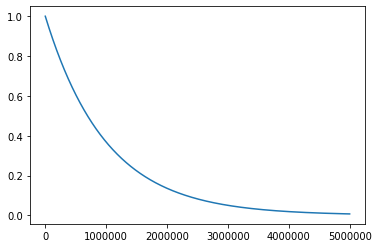

In [15]:
plt.plot(time, epsilon)
plt.show()